In [2]:
import numpy as np
import pyPLUTO as pp
from astropy.io import ascii
import os
import sys
from ipywidgets import interactive, widgets,fixed
from IPython.display import Audio, display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation,FFMpegWriter
from matplotlib import rc,rcParams
from scipy.integrate import quad
rc('text', usetex=True)
rcParams['figure.figsize'] = (15., 6.0)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['text.latex.preamble'] = ['\\usepackage{siunitx}','\\usepackage[version=3]{mhchem}']
import seaborn
seaborn.despine()
seaborn.set_style('white', {'axes.linewidth': 0.5, 'axes.edgecolor':'black'})
seaborn.despine(left=True)
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 1

In [4]:
%aimport f

In [5]:
def pprofile(c,VAR,VAR2=None,steps=5,itlim=-1,ix=128,yprop=128,tdk='Myrs',yl='n $(\si{cm^{-3}})$',yl2='Pressure',
              alpha=1.0,alpha2=1.0,sc1='log',sc2='linear',secopt='left',Save_Figure='',xlim=[None,None],ylim=[None,None],):
    
    if (VAR2<> None and secopt=='left'): 
        plt.figure(figsize=(12,5.2))
    else: #ax.set_aspect('equal')
        plt.figure(figsize=(7.5,6.5))
    ax=plt.subplot()
    datafolder='../Document/DataImages/'
    T=np.linspace(0,c['T'][:itlim].shape[0]-1,steps,dtype=int)
    if VAR == 'Cs' :
        d=1e-5 *f.V0*np.sqrt(5./3. *c['PRS']/c['RHO'])
    else:    
        d=c[VAR] if VAR <> 'Temp' else c['PRS']*f.Temp0/c['RHO']
    
    if VAR2<>None:
        ax2=ax.twinx()
        ax2.set_ylabel(yl2)
        if secopt=='left':
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            ax2.yaxis.tick_left()
            ax2.yaxis.set_label_position("left")
            ax.vlines(0,0.8*d.min(),1.4*d.max(),linewidth=0.5)
            ls='-'
        else:
            ls='--'
        d2=c[VAR2] if VAR2 <> 'Temp' else c['PRS']*f.Temp0/c['RHO']
        ax2.set_yscale(sc2)
    td= 1e6 if tdk == 'Myrs' else 1e3 if tdk == 'kyrs' else 1.
    for t in T:
        ax.plot(c['X'][ix:]*10.,d[yprop,ix:,t],label='{:.1f} {}'.format(c['T'][t]/td,tdk),alpha=alpha)
        if VAR2<>None:
            if secopt=='left': 
                ax2.plot(c['X'][:ix]*10,d2[yprop,:ix,t],linestyle=ls,label='{:.1f} {}'.format(c['T'][t]/td,tdk),
                                alpha=alpha2)
            else:
                ax2.plot(c['X'][ix:]*10,d2[yprop,ix:,t],linestyle=ls,label='{:.1f} {}'.format(c['T'][t]/td,tdk),
                                alpha=alpha2)
    if steps<8: 
        ax.legend(loc='best')
    ax.set_ylim(0.8*d.min(),1.4*d.max()) 
    if VAR2<>None:
        ax2.set_xlim(xlim[0],xlim[1])
        ax2.set_ylim(ylim[0],ylim[1])
        if secopt=='left':
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
    ax.set_xlabel('X $(\si{pc})$')
    ax.set_ylabel(yl)
    ax.set_yscale(sc1)
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    plt.tight_layout()
    form='.png'
    if Save_Figure <> '': plt.savefig(datafolder+Save_Figure+form,bbox_inches='tight',format='png', dpi=100)

def quadruple(d,VAR,tdk='Myrs',Save_Figure='',cl='',nn=0,mspeed='km',rows=2,cols=2,xlim=[None,None],
              ylim=[None,None],tlim=None,datafolder='../Document/DataImages/'):
    """
    Plot a rows(=2) x cols(=2) Variable 
    """
    X,Y=d['X'],d['Y']
    Vx=d['Vx'] if nn>0 else 0
    Vy=d['Vy'] if nn>0 else 0
    T=np.linspace(0,d['T'].shape[0]-1,rows*cols,dtype=int) if tlim==None else np.linspace(0,tlim,rows*cols,dtype=int)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,
                            figsize=(cols*5,rows*5))
    i=0
    td=1e3 if tdk=='kyrs' else 1e6
    for ax in axes.flat:
        ext=[X.min(),X.max(),Y.min(),Y.max()]
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        #ax.add_artist(plt.Circle((0, 0), 1.0, color='r',fill=False,linestyle='--'))
        label = '{:.1f} {}'.format(d['T'][T[i]]/td,tdk)
        ax.set_title(label,fontsize=20)
        ax.grid(False)
        pc = ax.imshow(VAR[:,:,T[i]].T,cmap='viridis',origin='lower',aspect='equal',
                       extent=ext,vmin=VAR.min(),vmax=VAR.max())
        if nn>0:
            k=nn #distance from boundaries for first/last arrows
            sc=2. if mspeed =='max' else 5. if mspeed == 'c' else 1e-4
            q=pc.axes.quiver(X[k:-k:nn],Y[k:-k:nn],
                            Vx[:,:,T[i]][k:-k:nn,k:-k:nn].T,
                            Vy[:,:,T[i]][k:-k:nn,k:-k:nn].T,
                             scale=sc,alpha=0.5,width=0.002)
            if mspeed == 'c':
                pc.axes.quiverkey(q,0.05,1.02,1.,r'$1\si{c}$',labelpos='E',fontproperties={'weight': 'bold'})
            elif mspeed == 'max':
                mV=np.max(np.sqrt(Vx[np.argmin((d['Y']-ylim[0])**2):np.argmin((d['Y']-ylim[1])**2),
                                     np.argmin((d['X']-xlim[0])**2):np.argmin((d['X']-xlim[1])**2),T[i]]**2+
                                  Vy[np.argmin((d['Y']-ylim[0])**2):np.argmin((d['Y']-ylim[1])**2),
                                     np.argmin((d['X']-xlim[0])**2):np.argmin((d['X']-xlim[1])**2),T[i]]**2))
                pc.axes.quiverkey(q,0.05,1.02,mV,'{:.2f} c'.format(mV),labelpos='E',
                                  fontproperties={'weight': 'bold'})
            else:
                pc.axes.quiverkey(q,0.02,1.02,3.36e-6,r'$1\si{km.s^{-1}}$',labelpos='E',fontproperties={'weight': 'bold'})
            
        i=i+1
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0., 1.015, 1., 0.025*(np.float(cols)/rows)])#*(np.float(cols)/rows)
    cb=fig.colorbar(pc, cax=cbar_ax,orientation="horizontal",label=cl)
    cb.ax.tick_params(labelsize=17)
    cb.ax.xaxis.offsetText.set(size=20)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    form='.png'
    if Save_Figure <> '': plt.savefig(datafolder+Save_Figure+form,bbox_inches='tight',format='png', dpi=100)


        
def dprofile(c1,c2,VAR,steps=15,itlim=-1,ix=128,tdk='Myrs',yl='n $(\si{cm^{-3}})$',alpha=0.2,Save_Figure='',xlim=[None,None],
              ylim=[None,None]):
    plt.figure(figsize=(7.5,5.2))
    datafolder='../Document/DataImages/'
    T=np.linspace(0,min(c1['T'][:itlim].shape[0],c2['T'][:itlim].shape[0])-1,steps,dtype=int)
    if VAR == 'Cs' :
        d1=1e-5 *f.V0*np.sqrt(5./3. *c1['PRS']/c1['RHO'])
        d2=1e-5 *f.V0*np.sqrt(5./3. *c2['PRS']/c2['RHO'])
    else:  
        d1=c1[VAR] if VAR <> 'Temp' else c1['PRS']*f.Temp0/c1['RHO']
        d2=c2[VAR] if VAR <> 'Temp' else c2['PRS']*f.Temp0/c2['RHO']
    td= 1e6 if tdk == 'Myrs' else 1e3 if tdk == 'kyrs' else 1.
    for t in T:
        plt.plot(c1['X'][ix:]*10.,d1[d1.shape[0]/2,ix:,t],label='{:.1f} {}'.format(c1['T'][t]/td,tdk),alpha=alpha)
        plt.plot(c2['X'][ix:]*10.,d2[d2.shape[0]/2,ix:,t],'--',label='{:.1f} {}'.format(c2['T'][t]/td,tdk),alpha=alpha)
    if steps<8: 
        plt.legend(loc='best')
    plt.ylim(0.8*min(d1.min(),d2.min()),1.4*max(d1.max(),d2.max()))  
    plt.xlim(xlim)
    plt.xlabel('X $(\si{pc})$')
    plt.ylabel(yl)
    plt.yscale('log')
    plt.tight_layout()
    form='.png'
    if Save_Figure <> '': plt.savefig(datafolder+Save_Figure+form,bbox_inches='tight')

def d3profile(c1,c2,VARS=['RHO','PRS','Temp'],steps=15,itlim=-1,ix=128,tdk='Myrs',
              yl=['n $(\si{cm^{-3}})$','Pressure (code units)','Temperature (K)'],
              alpha=0.35,Save_Figure=''):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(7.5,15))
    datafolder='../Document/DataImages/'
    T=np.linspace(0,min(c1['T'][:itlim].shape[0],c2['T'][:itlim].shape[0])-1,steps,dtype=int)
    
    for i,ax in enumerate(axes.flat):
        VAR=VARS[i]
        d1=c1[VAR] if VAR <> 'Temp' else c1['PRS']*f.Temp0/c1['RHO']
        d2=c2[VAR] if VAR <> 'Temp' else c2['PRS']*f.Temp0/c2['RHO']
        td= 1e6 if tdk == 'Myrs' else 1e3 if tdk == 'kyrs' else 1.
        for t in T:
            a=(0.6/T.shape[0])*t+0.4*np.exp(-(t-T.shape[0])**2)
            ax.plot(c1['X'][ix:]*10.,d1[d1.shape[0]/2,ix:,t],label='{:.1f} {}'.format(c1['T'][t]/td,tdk),alpha=a)
            ax.plot(c2['X'][ix:]*10.,d2[d2.shape[0]/2,ix:,t],'--',label='{:.1f} {}'.format(c2['T'][t]/td,tdk),alpha=a)
        if steps<8: 
            ax.legend(loc='best')
        ax.set_ylim(0.8*min(d1.min(),d2.min()),1.4*max(d1.max(),d2.max()))
        ax.set_ylabel(yl[i])
        ax.set_yscale('log')
    ax.set_xlabel('X $(\si{pc})$')
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    plt.tight_layout()
    if Save_Figure <> '': plt.savefig(datafolder+Save_Figure,bbox_inches='tight')        

## No Cooling (just a coud)

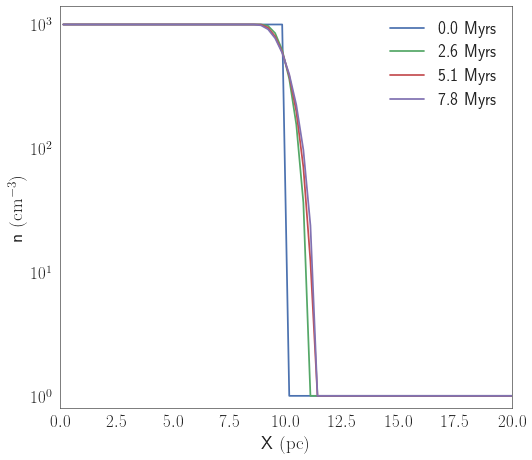

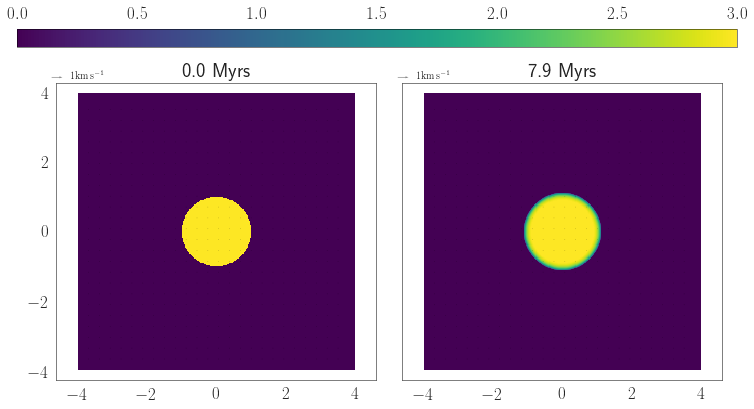

In [6]:
NC=np.load('../Data/noCooling.npz')
f.pprofile(NC,'RHO',steps=4,tdk='Myrs',Save_Figure='NoCoolingRHOprofile',xlim=[0,20])
f.quadruple(NC,np.log10(NC['RHO']),rows=1,nn=10,Save_Figure='NoCoolingRHOquad')
#pprofile(NC,'PRS',steps=3,tdk='Myrs',yl='Pressure (code units)')

## Tabulated Cooling

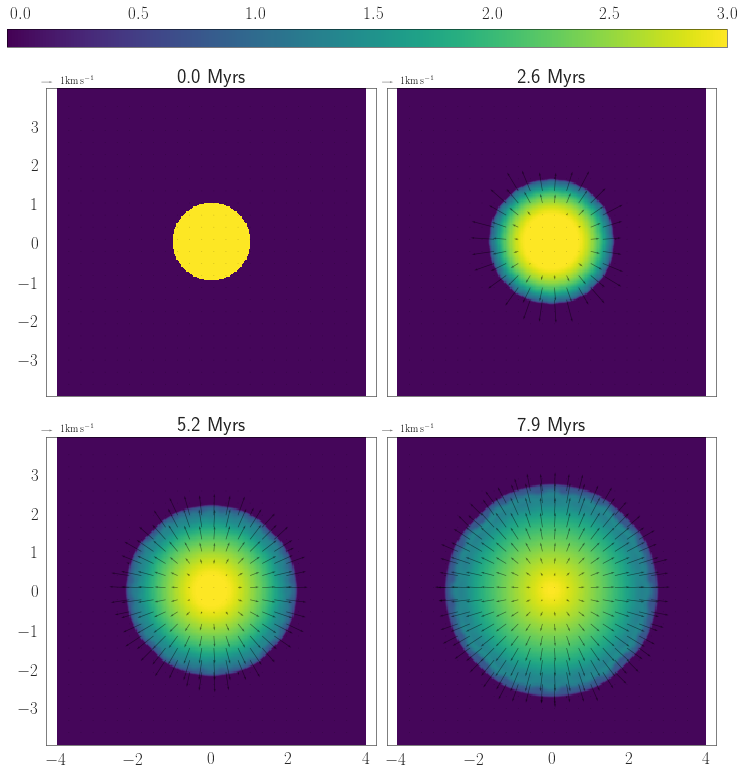

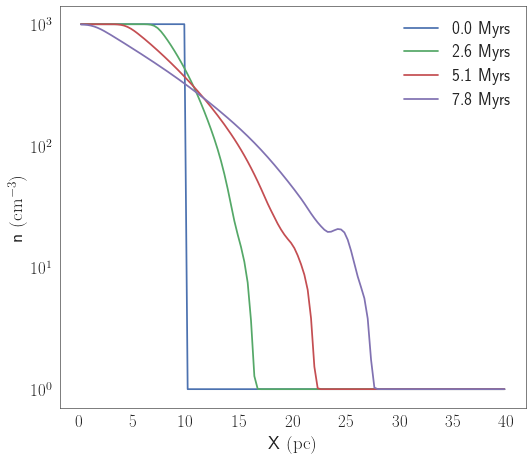

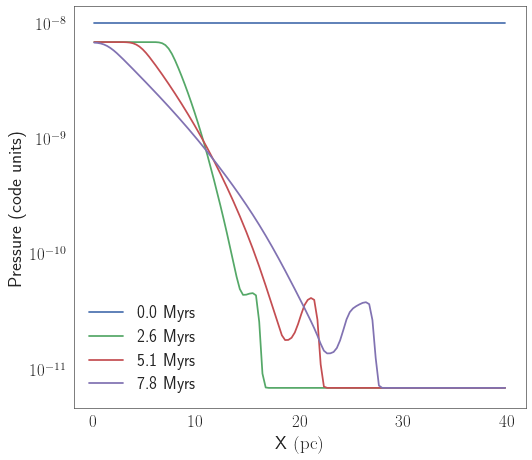

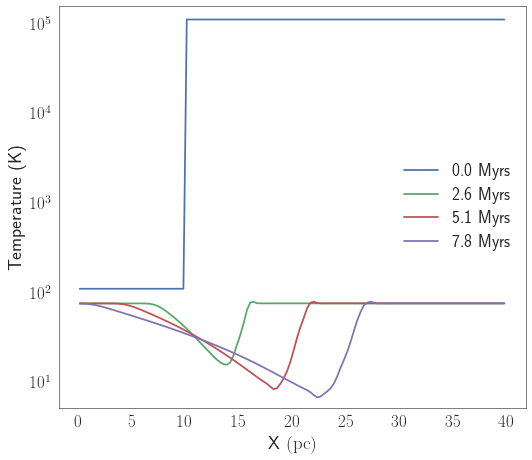

In [7]:
TC=np.load('../Data/Tabulated.npz')
f.quadruple(TC,np.log10(TC['RHO']),rows=2,nn=10,Save_Figure='TabCoolingRHOquad')
f.pprofile(TC,'RHO',steps=4,tdk='Myrs',Save_Figure='TabCoolingRHOprofile')
f.pprofile(TC,'PRS',steps=4,tdk='Myrs',yl='Pressure (code units)',Save_Figure='TabCoolingPRSprofile')
f.pprofile(TC,'Temp',steps=4,tdk='Myrs',yl='Temperature (K)',Save_Figure='TabCoolingTMPprofile')

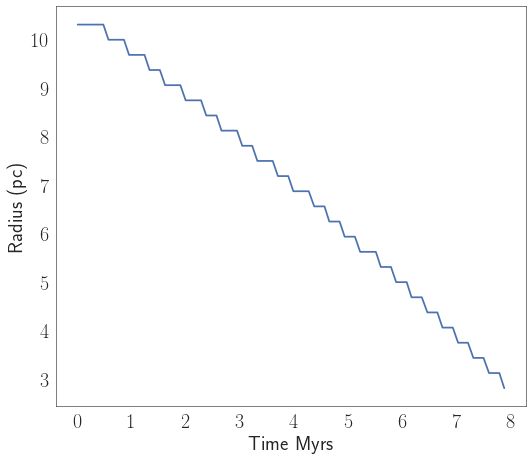

In [8]:
f.RadiusPlot(TC,Save_Figure='TabCoolingRadius.png')

## Tabulated Cooling 
### Micro Analysis

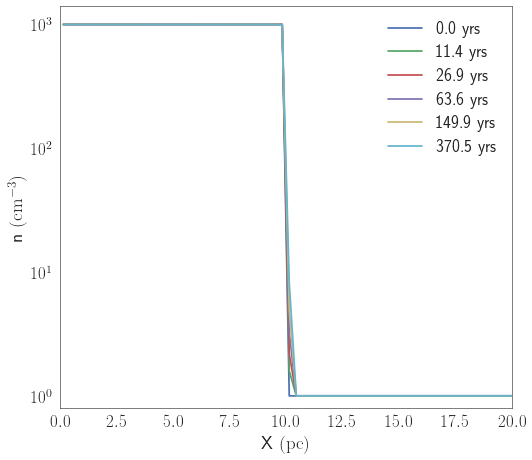

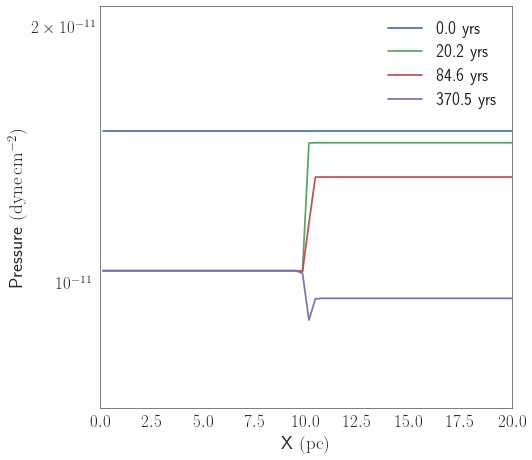

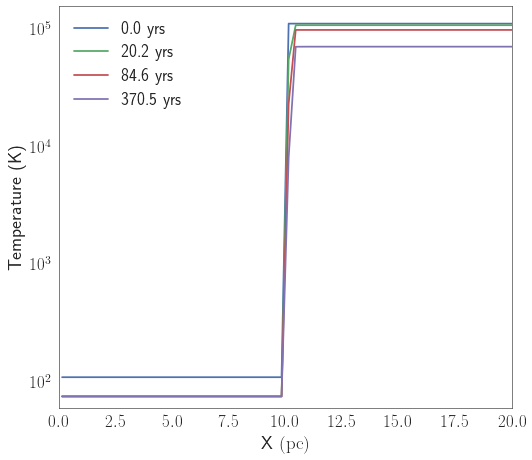

In [9]:
TCm=np.load('../Data/Tabulated-micro.npz')
f.pprofile(TCm,'RHO',steps=6,tdk='yrs',Save_Figure='TabCoolingPRSprofile-micro',xlim=[0,20])
f.pprofile(TCm,'PRS',steps=4,tdk='yrs',yl='Pressure $(\si{dyne.cm^{-2}})$',xlim=[0,20],y0=f.PRS0,Save_Figure='TabCoolingPRSprofile-micro')
f.pprofile(TCm,'Temp',steps=4,tdk='yrs',yl='Temperature (K)',xlim=[0,20],Save_Figure='TabCoolingTMPprofile-micro')

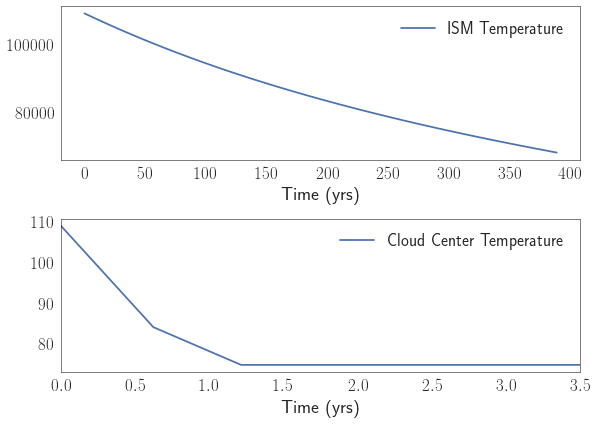

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(1.4*6.,1*6.))
axes[0].plot(TCm['T'], TCm['PRS'][12,12,:]*f.Temp0/(TCm['RHO'][12,12,:]),label='ISM Temperature')
axes[1].plot(TCm['T'], TCm['PRS'][128,128,:]*f.Temp0/(TCm['RHO'][128,128,:]),label='Cloud Center Temperature')
axes[1].set_xlim(0,3.5)
for ax in axes:
    ax.set_xlabel('Time (yrs)')
    #ax.set_yscale('log')
    ax.legend()
plt.tight_layout()
plt.savefig('/home/astromix/astro/MasterThesis/Document/DataImages/TabCoolingTMPcenterISM.png',bbox_inches='tight')

## SN Cooling

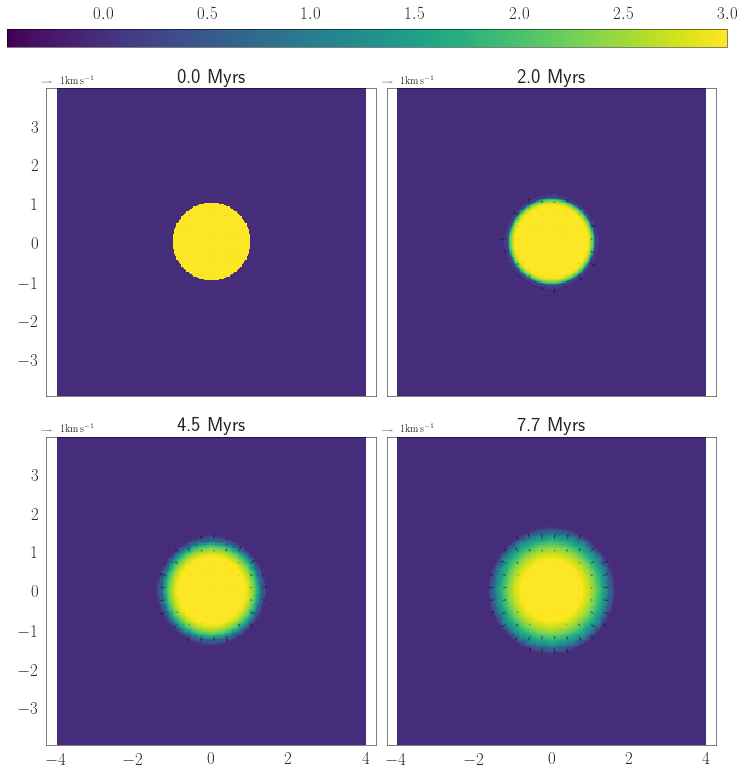

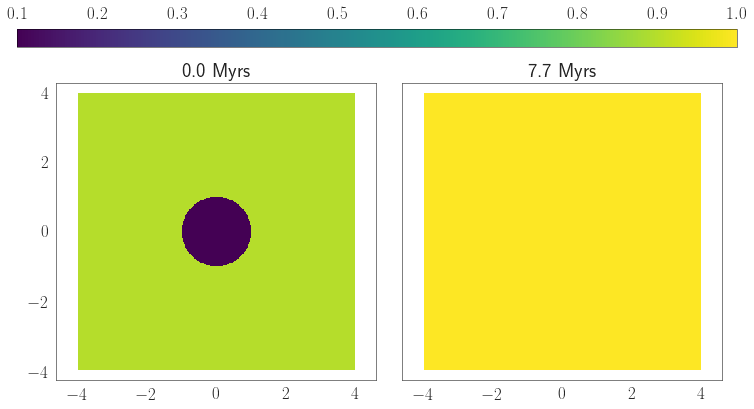

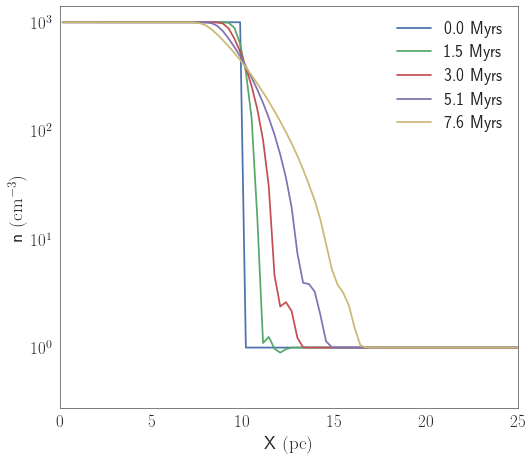

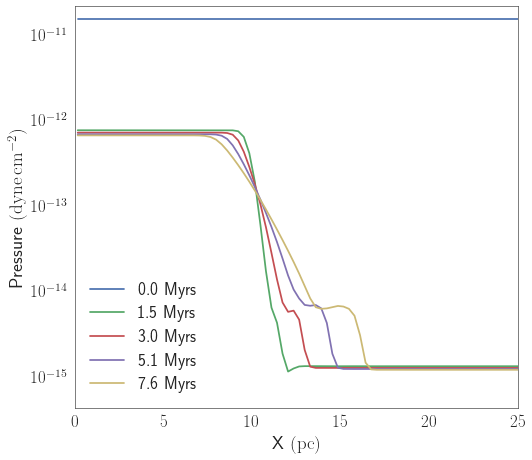

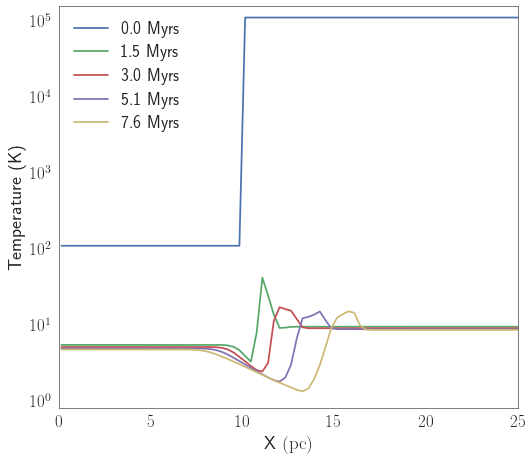

In [22]:
SC=np.load('../Data/SNCooling.npz')
f.quadruple(SC,np.log10(SC['RHO']),nn=10,Save_Figure='SNCoolingRHOquad')
f.quadruple(SC,SC['x_HI'],rows=1,Save_Figure='SNCoolingXHIquad')
f.pprofile(SC,'RHO',steps=5,tdk='Myrs',Save_Figure='SNCoolingRHOprofile',sc2='log',xlim=[0,25])
f.pprofile(SC,'PRS',steps=5,tdk='Myrs',yl='Pressure $(\si{dyne.cm^{-2}})$',y0=f.PRS0,Save_Figure='SNCoolingPRSprofile',xlim=[0,25])
f.pprofile(SC,'Temp',steps=5,tdk='Myrs',yl='Temperature (K)',yl2='$\ce{HI}$ Ratio',Save_Figure='SNCoolingTMPprofile',secopt='right',xlim=[0,25])

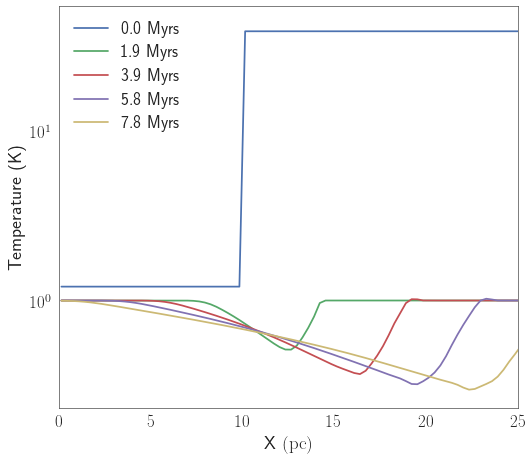

In [23]:
f.pprofile(TC,'Cs',steps=5,tdk='Myrs',yl='Temperature (K)',yl2='$\ce{HI}$ Ratio',secopt='right',xlim=[0,25])

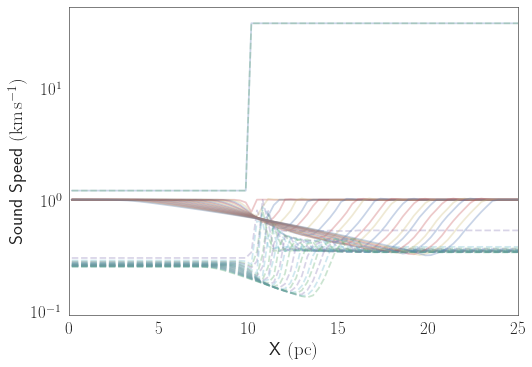

In [24]:
f.dprofile(TC,SC,'Cs',steps=25,tdk='Myrs',yl='Sound Speed $(\si{km.s^{-1}})$',xlim=[0,25],alpha=0.3,Save_Figure='TabSNSoundSpeed')

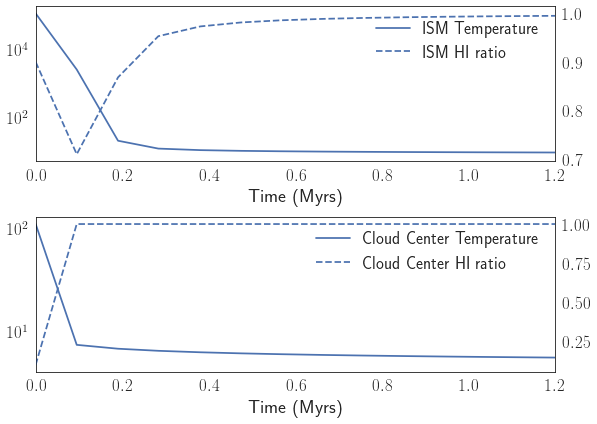

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(1.4*6.,1*6.))
lns0a=axes[0].plot(SC['T']/1e6, SC['PRS'][12,12,:]*f.Temp0/(SC['RHO'][12,12,:]),label='ISM Temperature')
ax0HI=axes[0].twinx()
lns0b=ax0HI.plot(SC['T']/1e6, SC['x_HI'][12,12,:],'--',label='ISM HI ratio')
#lns0c=ax0HI.plot(SC['T']/1e6, SC['x_HII'][12,12,:],'--',label='ISM HII ratio')
lns0 = lns0a+lns0b#+lns0c
labs0 = [l.get_label() for l in lns0]
axes[0].legend(lns0, labs0, loc='best')

lns1=axes[1].plot(SC['T']/1e6, SC['PRS'][128,128,:]*f.Temp0/(SC['RHO'][128,128,:]),label='Cloud Center Temperature')
axHI=axes[1].twinx()
lns2=axHI.plot(SC['T']/1e6, SC['x_HI'][128,128,:],'--',label='Cloud Center HI ratio')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axes[1].legend(lns, labs, loc=0)

for ax in axes:
    ax.set_xlabel('Time (Myrs)')
    ax.set_yscale('log')
    ax.set_xlim([0,1.2])
plt.tight_layout()
plt.savefig('/home/astromix/astro/MasterThesis/Document/DataImages/SNCoolingTMPcenterISM.png',bbox_inches='tight')

## Σύγκριση Tabulated Cooling με SN Cooling

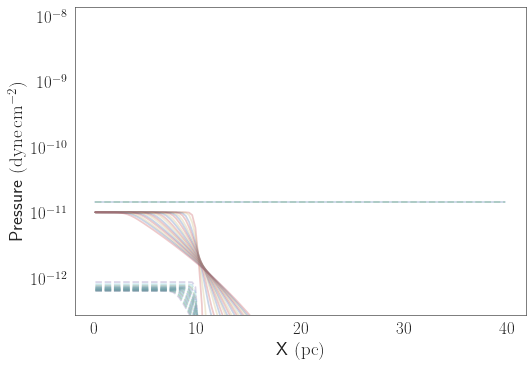

In [26]:
f.dprofile(TC,SC,'PRS',steps=20,alpha=0.3,yl='Pressure $(\si{dyne.cm^{-2}})$',y0=f.PRS0,Save_Figure='diffTabCoolSNCoolPRSprofile.png')

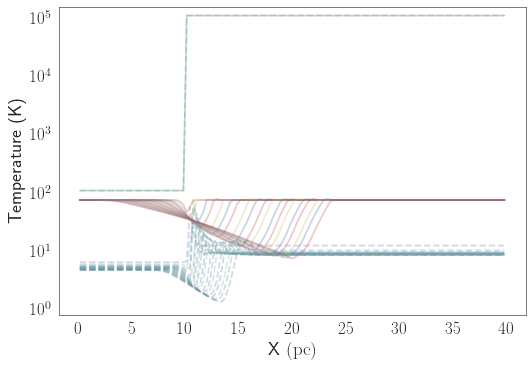

In [27]:
f.dprofile(TC,SC,'Temp',steps=20,alpha=0.3,yl='Temperature (K)',Save_Figure='diffTabCoolSNCoolPRSprofile.png')

## H2 Cooling

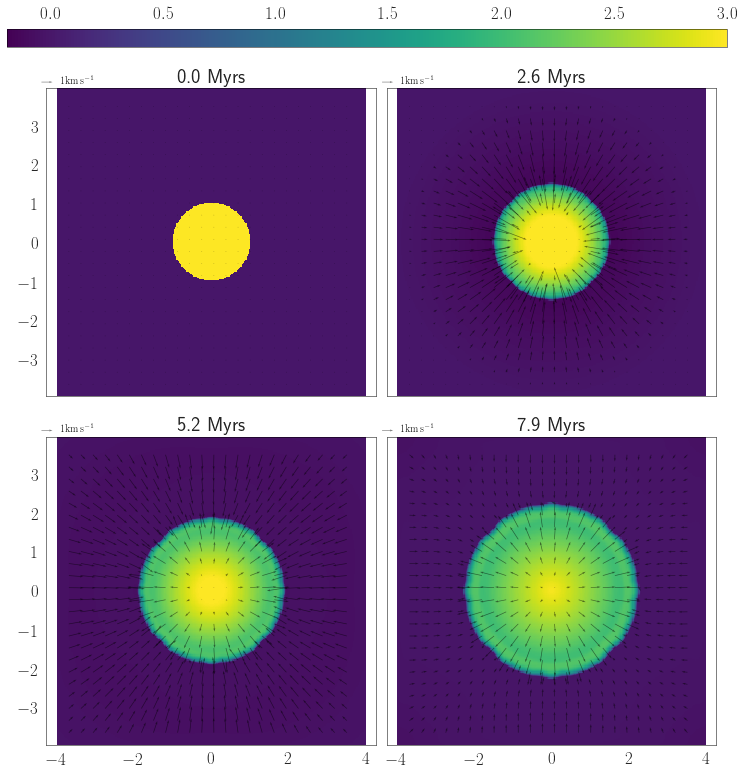

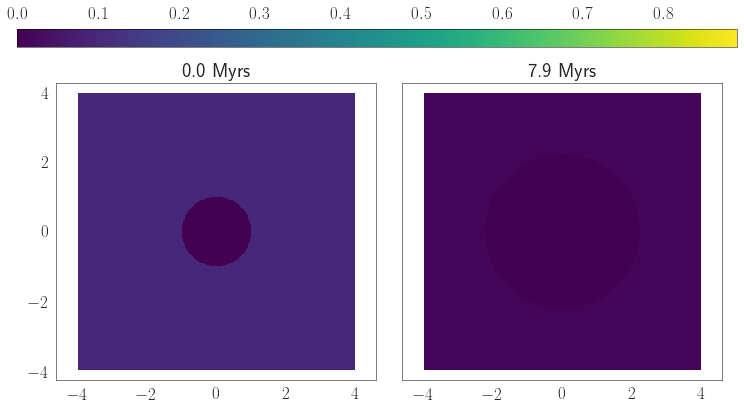

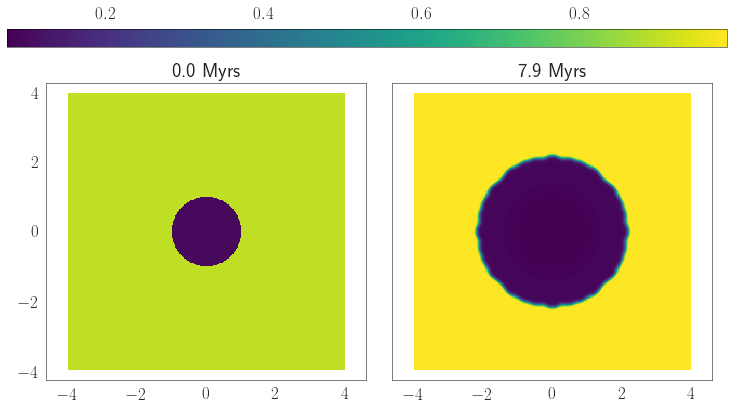

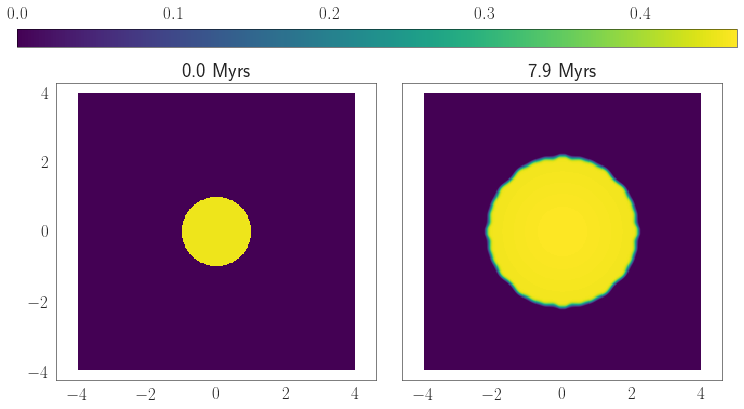

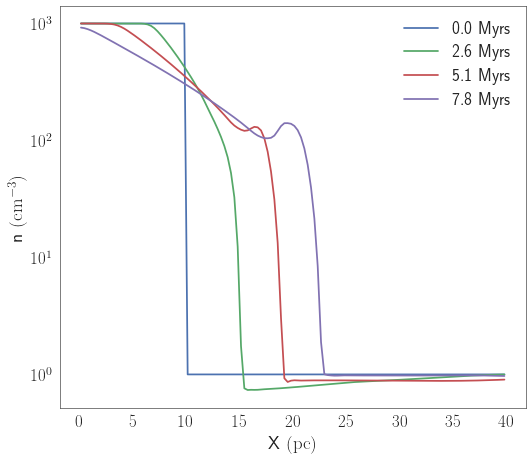

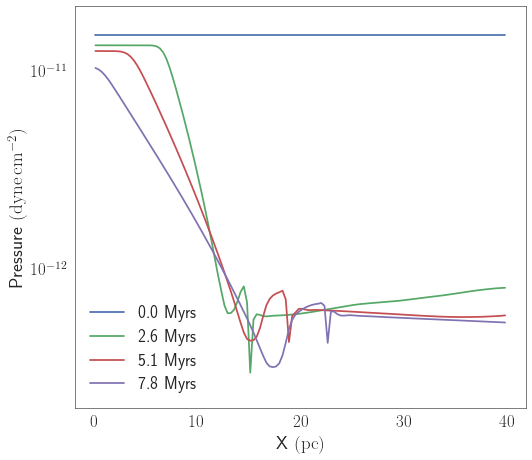

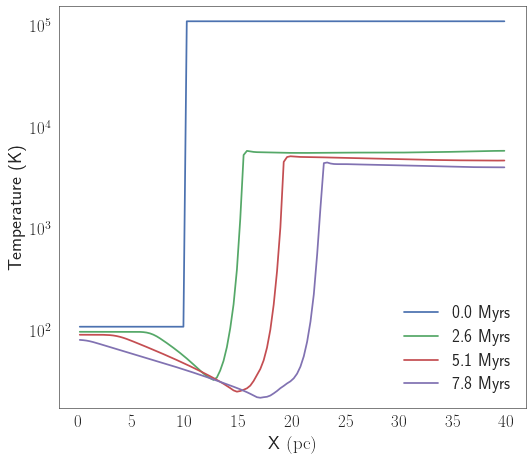

In [34]:
HC=np.load('../Data/H2Cooling.npz')
f.quadruple(HC,np.log10(HC['RHO']),nn=10,Save_Figure='H2CoolingRHOquad')
f.quadruple(HC,HC['x_HII'],rows=1,Save_Figure='H2CoolingHIIquad')
f.quadruple(HC,HC['x_HI'],rows=1,Save_Figure='H2CoolingHIquad')
f.quadruple(HC,HC['x_H2'],rows=1,Save_Figure='H2CoolingH2quad')
f.pprofile(HC,'RHO',steps=4,tdk='Myrs',Save_Figure='H2CoolingRHOprofile')
f.pprofile(HC,'PRS',steps=4,tdk='Myrs',yl='Pressure $(\si{dyne.cm^{-2}})$',y0=f.PRS0,Save_Figure='H2CoolingPRSprofile')
f.pprofile(HC,'Temp',steps=4,tdk='Myrs',yl='Temperature (K)',Save_Figure='H2CoolingTMPprofile')

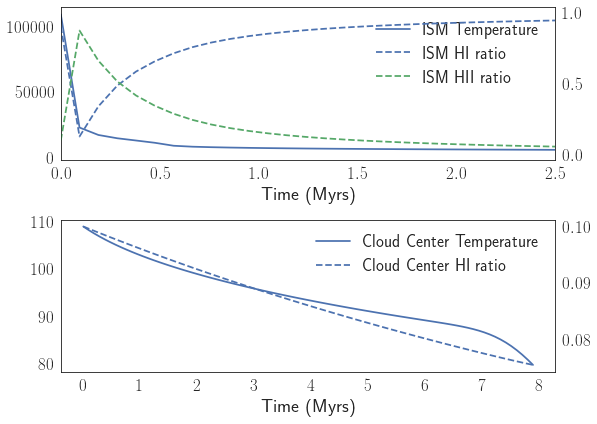

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(1.4*6.,1*6.))
lns0a=axes[0].plot(HC['T']/1e6, HC['PRS'][12,12,:]*f.Temp0/(HC['RHO'][12,12,:]),label='ISM Temperature')
ax0HI=axes[0].twinx()
lns0b=ax0HI.plot(HC['T']/1e6, HC['x_HI'][12,12,:],'--',label='ISM HI ratio')
lns0c=ax0HI.plot(HC['T']/1e6, HC['x_HII'][12,12,:],'--',label='ISM HII ratio')
lns0 = lns0a+lns0b+lns0c
labs0 = [l.get_label() for l in lns0]
axes[0].legend(lns0, labs0, loc='best')
plt.xlim(0,2.5)

lns1=axes[1].plot(HC['T']/1e6, HC['PRS'][128,128,:]*f.Temp0/(HC['RHO'][128,128,:]),label='Cloud Center Temperature')
axHI=axes[1].twinx()
lns2=axHI.plot(HC['T']/1e6, HC['x_HI'][128,128,:],'--',label='Cloud Center HI ratio')
#lns3=axHI.plot(HC['T']/1e6, HC['x_H2'][128,128,:],'--',label='Cloud Center H2 ratio')
lns = lns1+lns2#+lns3
labs = [l.get_label() for l in lns]
axes[1].legend(lns, labs, loc=0)

for ax in axes:
    ax.set_xlabel('Time (Myrs)')
    #ax.set_yscale('log')
plt.tight_layout()
plt.savefig('/home/astromix/astro/MasterThesis/Document/DataImages/H2CoolingTMPcenterISM.png',bbox_inches='tight')

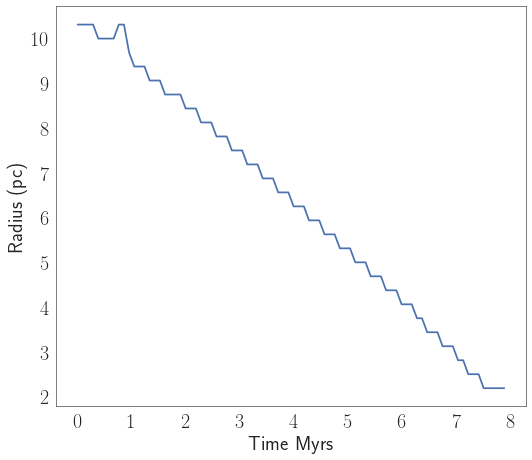

In [30]:
f.RadiusPlot(HC,Save_Figure='H2CoolingRadius.png')

## Σύγκριση H2Cooling με SN Cooling

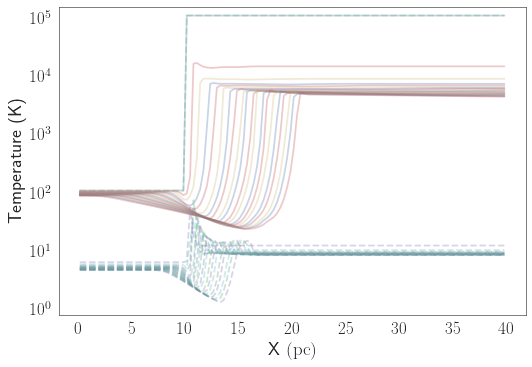

In [31]:
f.dprofile(HC,SC,'Temp',steps=20,alpha=0.3,yl='Temperature (K)',Save_Figure='diffH2CoolSNCoolPRSprofile.png')

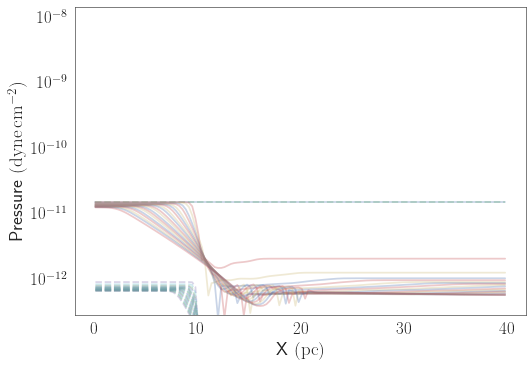

In [33]:
f.dprofile(HC,SC,'PRS',steps=20,alpha=0.3,yl='Pressure $(\si{dyne.cm^{-2}})$',y0=f.PRS0,Save_Figure='diffH2CoolSNCoolPRSprofile.png')

# ======== Gravity ==============
## Νο Cooling (+Gravity)

NameError: global name 'f' is not defined

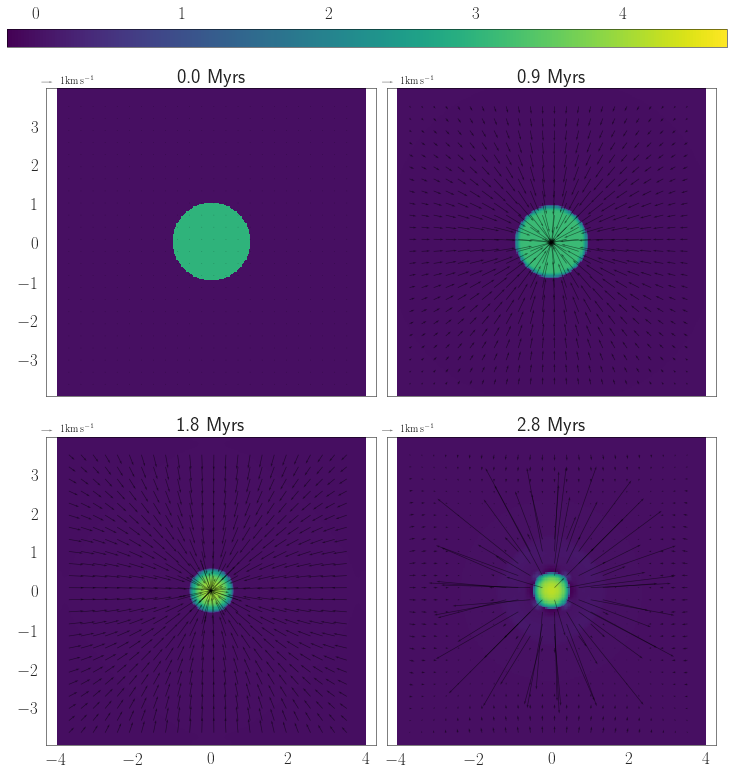

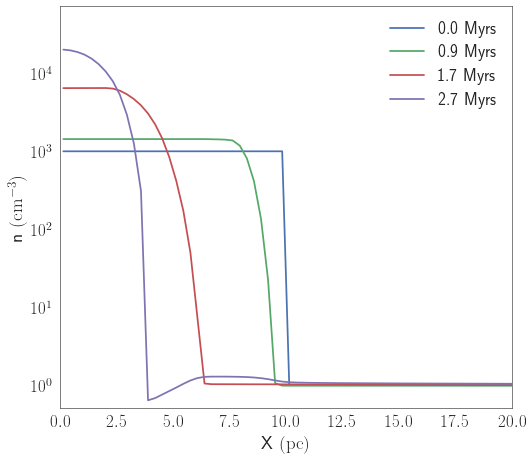

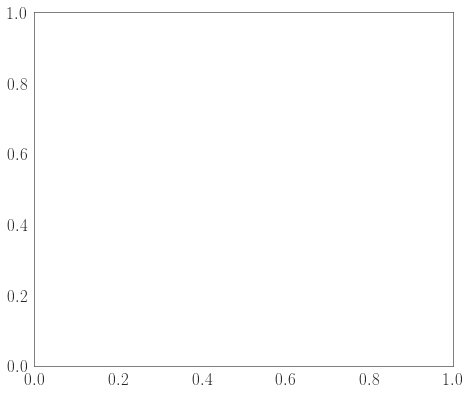

In [10]:
NCG=np.load('../Data/noCoolingG.npz')
f.quadruple(NCG,np.log10(NCG['RHO']),rows=2,nn=10,tlim=29,Save_Figure='NoCoolGRquad')
f.pprofile(NCG,'RHO',steps=4,itlim=29,tdk='Myrs',Save_Figure='NoCoolGRHOprofile',sc2='log',xlim=[0,20])
f.pprofile(NCG,'Temp',steps=4,itlim=29,tdk='Myrs',yl='Temperature (K)',Save_Figure='NoCoolGTempprofile',sc2='log',xlim=[0,20])
f.pprofile(NCG,'PRS',steps=4,itlim=29,tdk='Myrs',yl='Pressure',Save_Figure='NoCoolGPRSprofile',sc2='log',xlim=[0,20])

## Tabulated Cooling, with Gravity

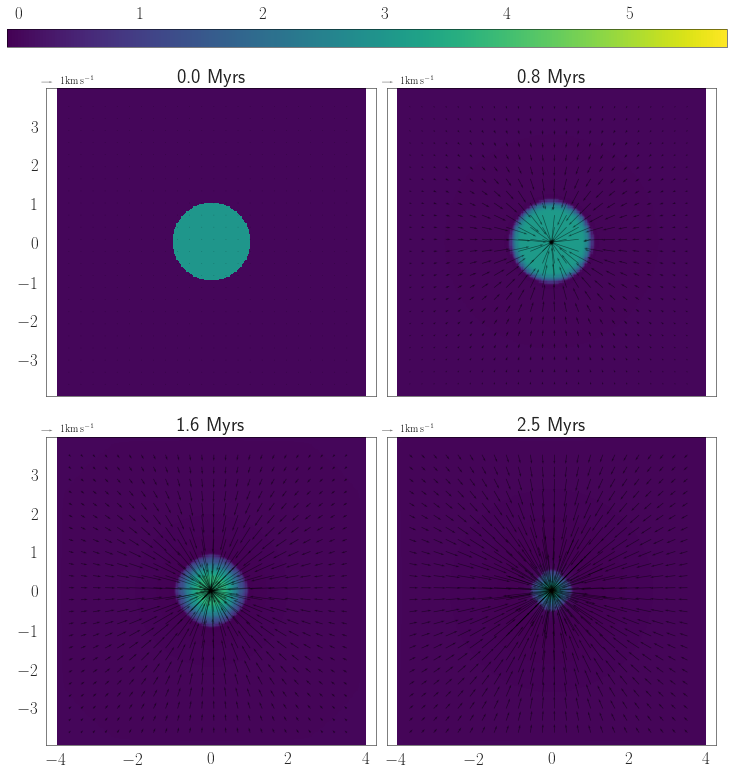

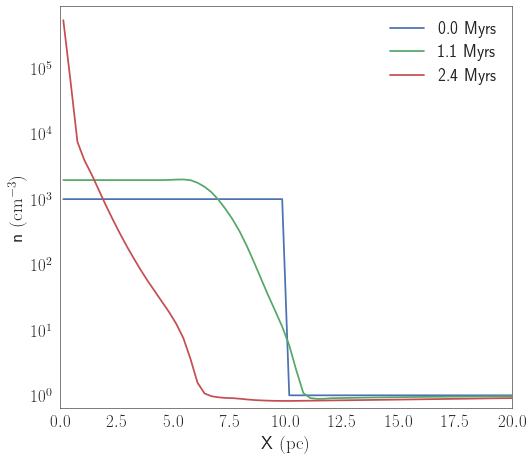

In [77]:
TCG=np.load('../Data/TabulatedG.npz')
quadruple(TCG,np.log10(TCG['RHO']),rows=2,nn=10,tlim=26)
pprofile(TCG,'RHO',steps=3,itlim=26,tdk='Myrs',sc2='log',xlim=[0,20])
#pprofile(TCG,'PRS',steps=3,tdk='Myrs',yl='Pressure (code units)')

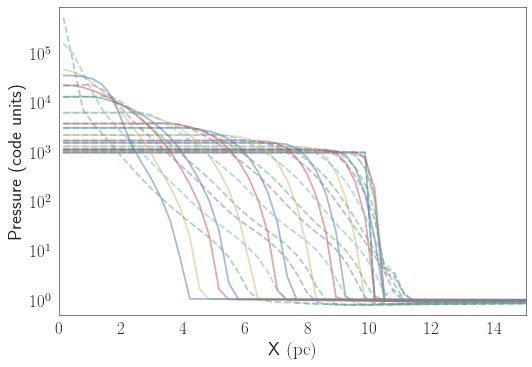

In [82]:
dprofile(NCG,TCG,'RHO',steps=16,itlim=26,alpha=0.5,yl='Pressure (code units)',xlim=[0,15],Save_Figure='diffNOCoolSNCoolRHOprofileG.png')

## SN Cooling, with Gravity

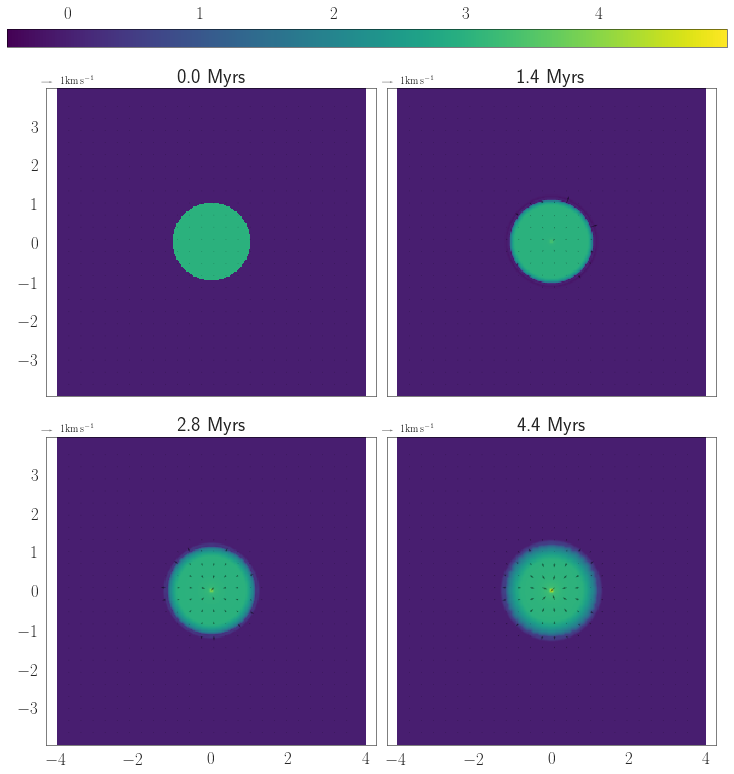

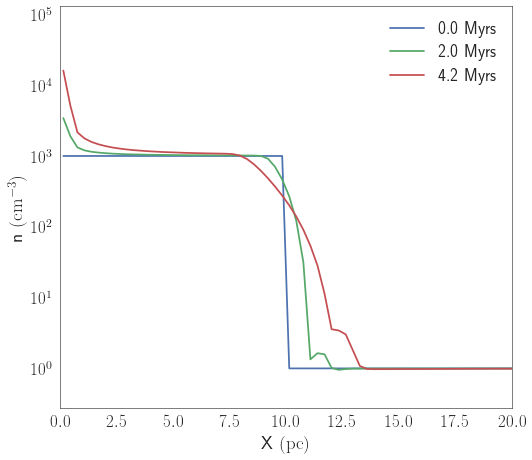

In [84]:
SCG=np.load('../Data/SNCoolingG.npz')
quadruple(SCG,np.log10(SCG['RHO']),rows=2,nn=10,tlim=46)
pprofile(SCG,'RHO',steps=3,itlim=46,tdk='Myrs',sc2='log',xlim=[0,20])
#pprofile(TCG,'PRS',steps=3,tdk='Myrs',yl='Pressure (code units)')

## H2 Cooling, with Gravity

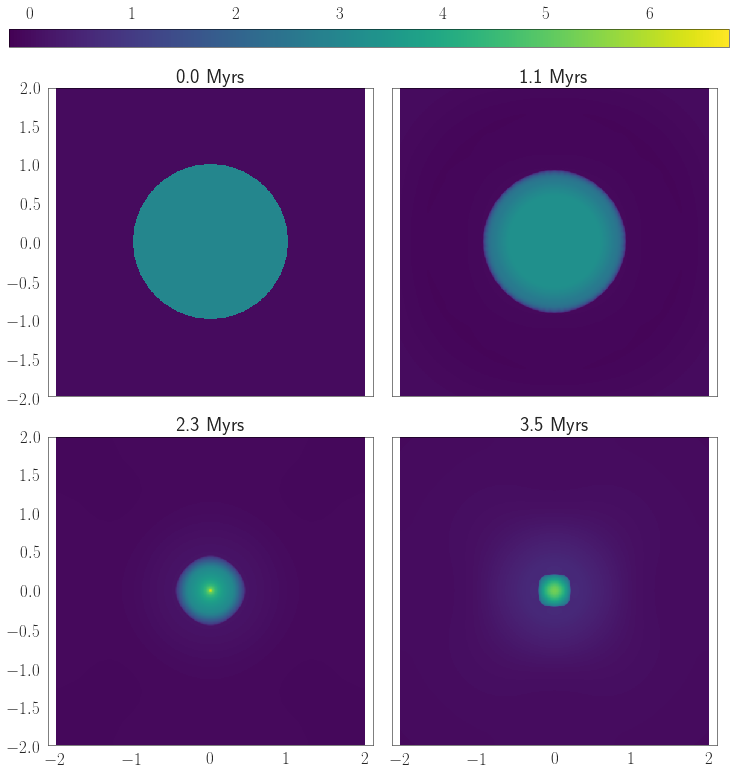

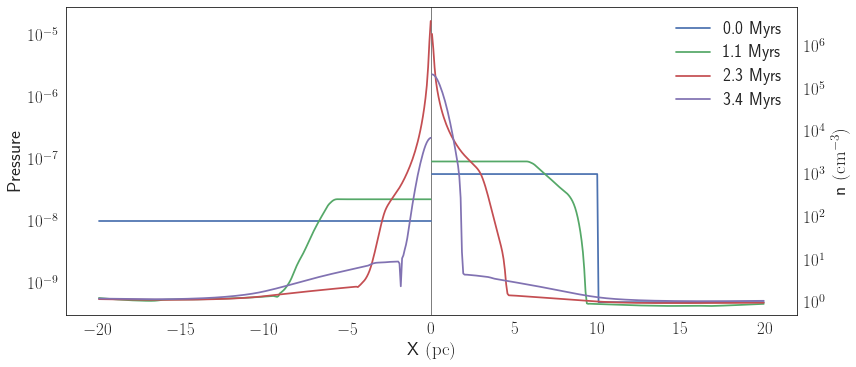

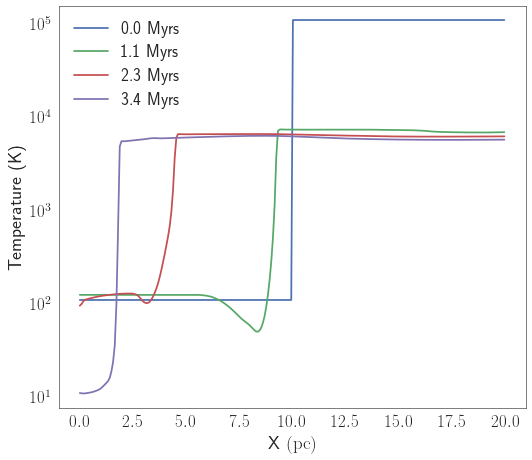

In [86]:
HCG=np.load('../Data/H2CoolingG512.npz')
quadruple(HCG,np.log10(HCG['RHO']))
#f.quadruple(HCG,HCG['x_HII'],rows=1,nn=10)
#f.quadruple(HCG,HCG['x_HI'],rows=1,nn=10)
#f.quadruple(HCG,HCG['x_H2'],rows=1,nn=10)
pprofile(HCG,'RHO','PRS',steps=4,tdk='Myrs',ix=256,yprop=256,sc2='log')
pprofile(HCG,'Temp',steps=4,tdk='Myrs',yl='Temperature (K)',ix=256,yprop=256)

In [ ]:
f.RadiusPlot(HCG,radscale=40./512.,mid=256)

In [ ]:
mid=256
print HCG['RHO'][mid,mid,:].max()
ind= HCG['RHO'][mid,mid,:].argmax()
print ind,HCG['T'][ind]/1e6
print HCG['T'][ind]/1e6
xs=HCG['X'][mid:]/10.
ys=HCG['RHO'][mid,mid:,ind]*f.RHO0
ax=plt.subplot()
ax.plot(xs,ys)
axy=ax.twiny()
x0=0.001
yk=1e-17
for p in np.arange(-5,-1.5,0.5):
    y0=x0**(p)
    ax.plot(xs[(xs>0.01) & (xs<0.03)],(yk/y0)*xs[(xs>0.01) & (xs<0.03)]**(p),'--',label=p)
    ax.legend()
ax.set_yscale('log')
ax.set_ylabel('$ \\rho\, (\si{g.cm^{-3}})$')
ax.set_xlabel('$\si{pc}$')
ax.set_xlim(None,0.08)

In [ ]:
mid=256
fitxlim=0.03
print 'Maximum Denisty {:.1e}'.format(HCG['RHO'][mid,mid,:].max())
ind= HCG['RHO'][mid,mid,:].argmax()
print 'Maximum central Density Time {:.1f} Myrs (index={})'.format(HCG['T'][ind]/1e6,ind)
xs=HCG['X'][mid:]/10.
ys=HCG['RHO'][mid,mid:,ind]*f.RHO0

xsl=np.log(xs[xs<fitxlim])
ysl=np.log(ys[xs<fitxlim])
from scipy.optimize import curve_fit
def ff(x,a,b,): return a*x+b #return a*x**b
p,dp=curve_fit(ff,xsl,ysl,[0.1,-50.])
print p,np.sqrt(np.diag(dp))
xx=np.linspace(0,fitxlim,100)
plt.plot(xs,ys)
plt.plot(xx,np.exp(p[1])*xx**(p[0]),'--',label='{:.1f}'.format(p[0]))
plt.plot(xx,(yk/(x0**(-1)))*xx**(-1),'--',label='-1')
plt.yscale('log')
plt.ylabel('$ \\rho\, (\si{g.cm^{-3}})$')
plt.xlabel('$\si{pc}$')
plt.legend()
plt.xlim(None,0.045)

In [ ]:
d3profile(NCG,HCG,steps=30,itlim=30)

In [ ]:
#HCG2=np.load('../Data/H2CoolingGtest.npz')
#f.quadruple(HCG2,np.log10(HCG2['RHO']),rows=3,nn=10)
#f.quadruple(HCG2,HCG2['x_HII'],rows=1,nn=10)
#f.quadruple(HCG2,HCG2['x_HI'],rows=1,nn=10)
#f.quadruple(HCG2,HCG2['x_H2'],rows=1,nn=10)
#pprofile(HCG2,'RHO',steps=10,tdk='Myrs')
#pprofile(HCG2,'PRS',steps=7,tdk='Myrs',yl='Pressure (code units)')

In [ ]:
#f.RadiusPlot(HCG2,radscale=20.*10/256.)

## Σύγκριση

### Cooling VS NoCooling

In [ ]:
d3profile(NC,TC,Save_Figure='NC-TC.png')
d3profile(NC,SC,Save_Figure='NC-SC.png')
d3profile(NC,HC,Save_Figure='NC-HC.png')
d3profile(TC,SC,Save_Figure='TC-SC.png')
d3profile(TC,HC,Save_Figure='TC-HC.png')
d3profile(SC,HC,Save_Figure='SC-HC.png')